### Импортируем библиотеки

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
plt.rcParams['figure.figsize'] = [22, 11]

### Напишем запрос к бд и посмотрим на данные

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

In [4]:
df = ph.read_clickhouse(query, connection=connection)

In [5]:
df.head(10)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
5,2,131473,14,134,0.104478
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,26,128,0.203125
9,2,24239,40,90,0.444444


In [6]:
df.groupby('exp_group').ctr.count().reset_index()

,exp_group,ctr
0,1,10079
1,2,9952


### Сравним среднее CTR двух групп

In [7]:
df.groupby('exp_group').ctr.mean().reset_index()

,exp_group,ctr
0,1,0.215605
1,2,0.214419


### Оценим 2 группы по гистограмме

<AxesSubplot:xlabel='ctr', ylabel='Count'>

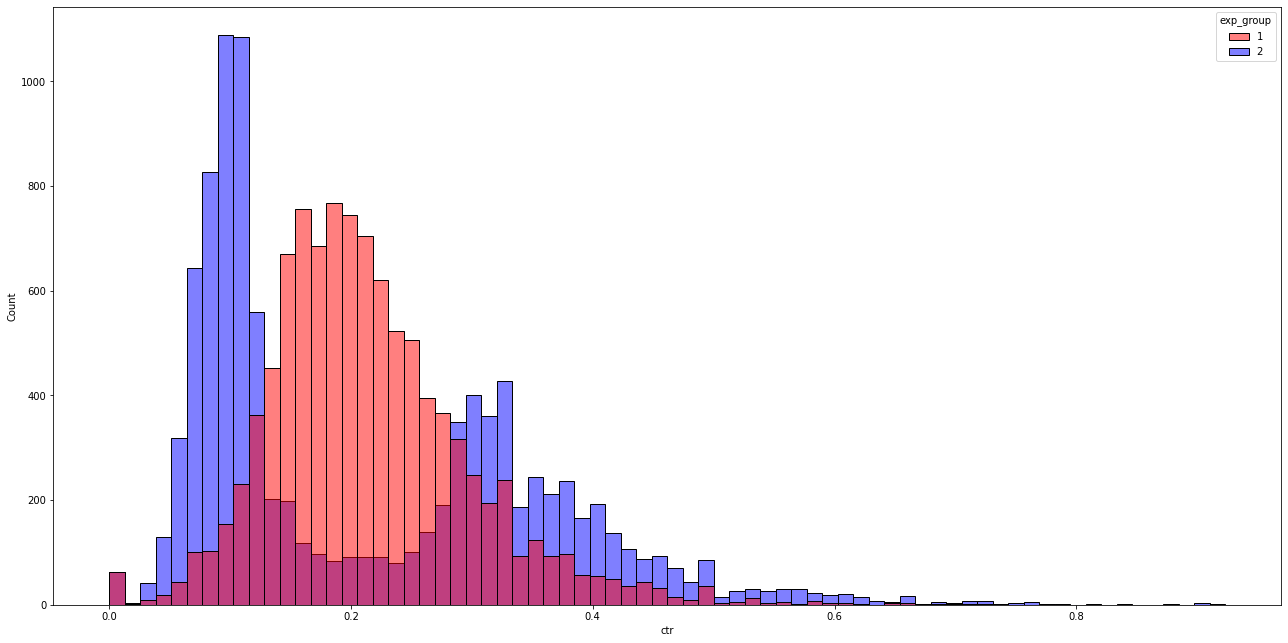

In [8]:
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### Видим у первой группы явно бОльшее количество CTR в зоне 0.1-0.3, у второй группы большое количество CTR сконцентрировано в зоне 0-0.1. Также во второй группе больше CTR в зоне 0.3-0.5, чем в первой
### Так как распределение групп отличается от нормального и существуют выбросы (ctr > 0.5), вместо обычного т-теста попробуем сравнить группы тестом Манна-Уитней

In [9]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

### Тест говорит нам что группы имеют существенное различие
### Попробуем сгладить значения 2 группы и проведем проведем t-тест на сглаженном ctr с параметром alpha=5

In [10]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [11]:
alpha = 5
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
group2 = df[df.exp_group == 2].copy()
group2['smooth_ctr']=df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, alpha), axis=1)

<AxesSubplot:xlabel='smooth_ctr', ylabel='Count'>

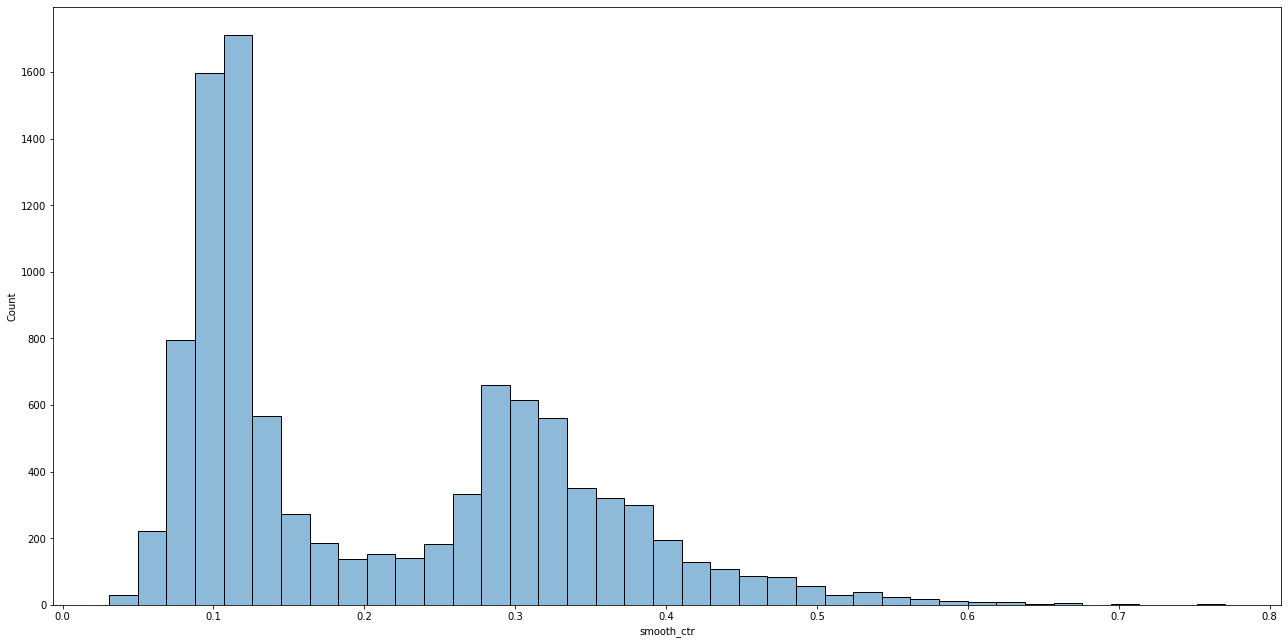

In [12]:
sns.histplot(data = group2, 
              x='smooth_ctr',  
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [13]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                group2.smooth_ctr,
                equal_var=False)

Ttest_indResult(statistic=3.2312222346883015, pvalue=0.0012349089306641313)

### По результатам t-теста на сглаженном CTR также видим что группы различаются
### Теперь сравним группы непараметрическим бустрапом

In [14]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [15]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [16]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

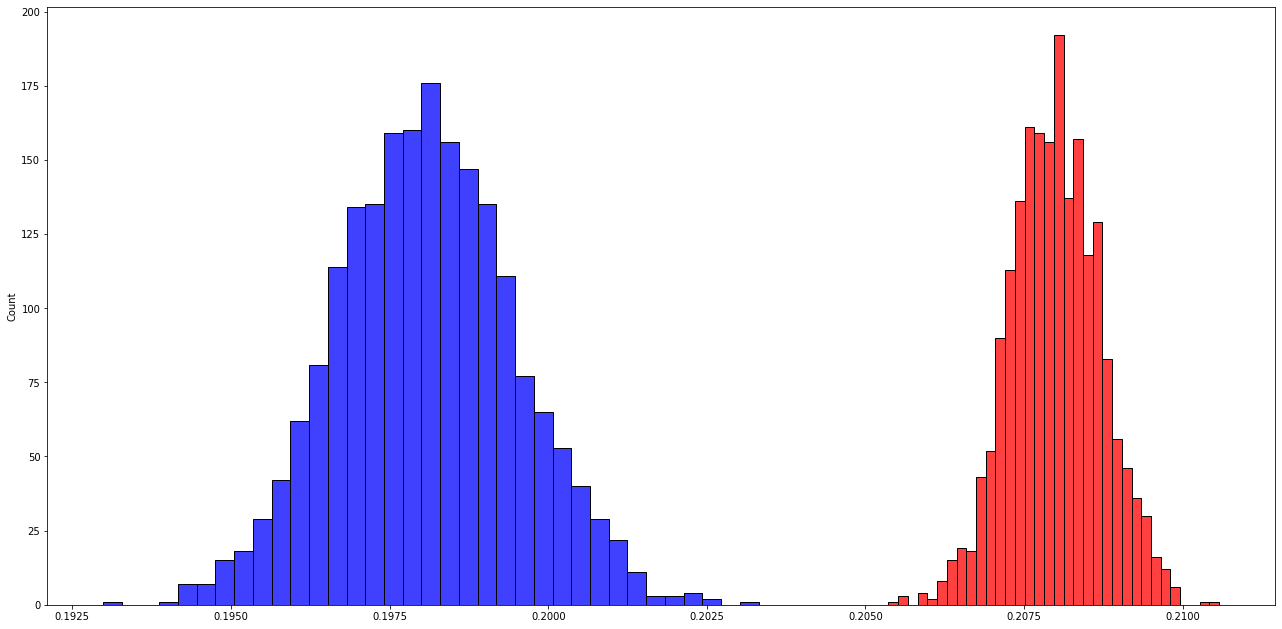

In [17]:
sns.histplot(ctr1, color = 'r')
sns.histplot(ctr2, color = 'b')

### В рельзультате бутсрапа мы видим разницу между контрольной первой (красная) и второй тестовой (синяя) группами

## Почему тесты сработали так как сработали? 
### Несмотря на то, что среднее ctr двух групп почти одинаковое, данные второй группы более разбросаны и имеют больше выбросов. Из-за этого тесты показали что группы разные. Ниже мы можем посмотреть насколько большой разброс данных во 2 группе (по сравнению с первой), сравнив квантили

In [18]:
df[df.exp_group == 1].describe()

,exp_group,user_id,likes,views,ctr
count,10079.0,10079.000000,10079.000000,10079.000000,10079.000000
mean,1.0,75540.955948,13.792142,66.299831,0.215605
std,0.0,53211.834816,9.798990,45.043411,0.084160
min,1.0,206.000000,0.000000,2.000000,0.000000
25%,1.0,22227.000000,7.000000,32.000000,0.160097
50%,1.0,109360.000000,12.000000,56.000000,0.203125
75%,1.0,126200.500000,19.000000,90.000000,0.257654
max,1.0,140500.000000,81.000000,311.000000,0.722222


In [19]:
df[df.exp_group == 2].describe()

,exp_group,user_id,likes,views,ctr
count,9952.0,9952.000000,9952.000000,9952.000000,9952.000000
mean,2.0,75142.800543,13.101387,66.148513,0.214419
std,0.0,53315.378033,11.838030,45.151210,0.144180
min,2.0,220.000000,0.000000,1.000000,0.000000
25%,2.0,21904.250000,5.000000,32.000000,0.095238
50%,2.0,109112.500000,9.000000,56.000000,0.142857
75%,2.0,126228.250000,17.000000,91.000000,0.325000
max,2.0,141164.000000,95.000000,321.000000,0.923077


## Опишите потенциальную ситуацию, когда такое изменение могло произойти
### Пользователям могли начать рекомендовать посты, которые им не нравятся. Вовлеченность пользователей в контент уменьшилась

## Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
### На основании проведенных тестов считаю что новый алгоритм не стоит накатывать